In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggpubr))

In [21]:
vaccine_cutoff <- as.Date("2021-01-01")
omicron_cutoff <- as.Date("2022-01-01")

# Time Course

In [6]:
historic_analysis_files <- list.files("data/selective_landscape/", recursive = FALSE, full.names = FALSE, pattern = "_hyphy_fubar_output.csv")
historic_analysis_dates <- gsub("_hyphy_fubar_output.csv", "", historic_analysis_files)

fubar_historic_output <- list()
for(file in historic_analysis_files){
    historic_analysis_date <- gsub("_hyphy_fubar_output.csv", "", file)
    fubar_historic_output[[historic_analysis_date]] <- data.table::fread(paste0("data/selective_landscape/", file), stringsAsFactors = FALSE) %>%
    mutate(
        gene = if_else(gene=="S", "Spike", gene),
        protein = if_else(protein=="S", "Spike", protein),
        position = paste0(protein, ": ", site)
    )
}

names(fubar_historic_output) <- paste0(names(fubar_historic_output), "-01")

In [7]:
all_fubar <- summary_tbl <- data.table()
for(freeze_date in names(fubar_historic_output)){
  for(x in unique(fubar_historic_output[[freeze_date]]$gene)){
    tmp <- fubar_historic_output[[freeze_date]] %>%
      filter(gene == x) %>% 
      mutate(freeze_date = as.Date(freeze_date))
      
    all_fubar <- rbind(all_fubar, tmp)
    
    summary_tbl <- rbind(
      summary_tbl,
      data.table(
        freeze_date = as.Date(freeze_date),
        gene = x,
        `Purifying Selection` = (tmp %>% filter( `Prob[alpha>beta]` >0.9 ) %>% nrow()) / nrow(tmp),
        `Diversifying Selection` = (tmp %>% filter(`Prob[alpha<beta]` > 0.9 ) %>% nrow()) / nrow(tmp)
      )
    )
    
    if(x == "Spike"){
      summary_tbl <- rbind(
        summary_tbl,
        data.table(
          freeze_date = as.Date(freeze_date),
          gene = "RBD",
          `Purifying Selection` = (tmp %>% filter( site %in% 319:541 & `Prob[alpha>beta]` >0.9 ) %>% nrow()) / length(319:541),
          `Diversifying Selection` = (tmp %>% filter( site %in% 319:541 & `Prob[alpha<beta]` > 0.9 ) %>% nrow()) / length(319:541)
        )
      )
    }
  }

}

In [14]:
selected_genes <- c("RBD", "Spike", "M", "N", "ORF3a", "ORF10", "ORF1b", "ORF1a")
tmp <- summary_tbl %>%
  mutate(
    gene = factor(gene, levels = c(selected_genes, setdiff(summary_tbl$gene, selected_genes) ))
  ) %>%
  reshape2::melt(id.vars = c("freeze_date", "gene")) %>%
  mutate(variable = factor(variable, levels = c("Purifying Selection", "Diversifying Selection"))); 

ordered_genes <- tmp %>% filter(freeze_date == "2022-09-01" & variable == "Purifying Selection") %>% arrange(desc(value)) %>% pull(gene)


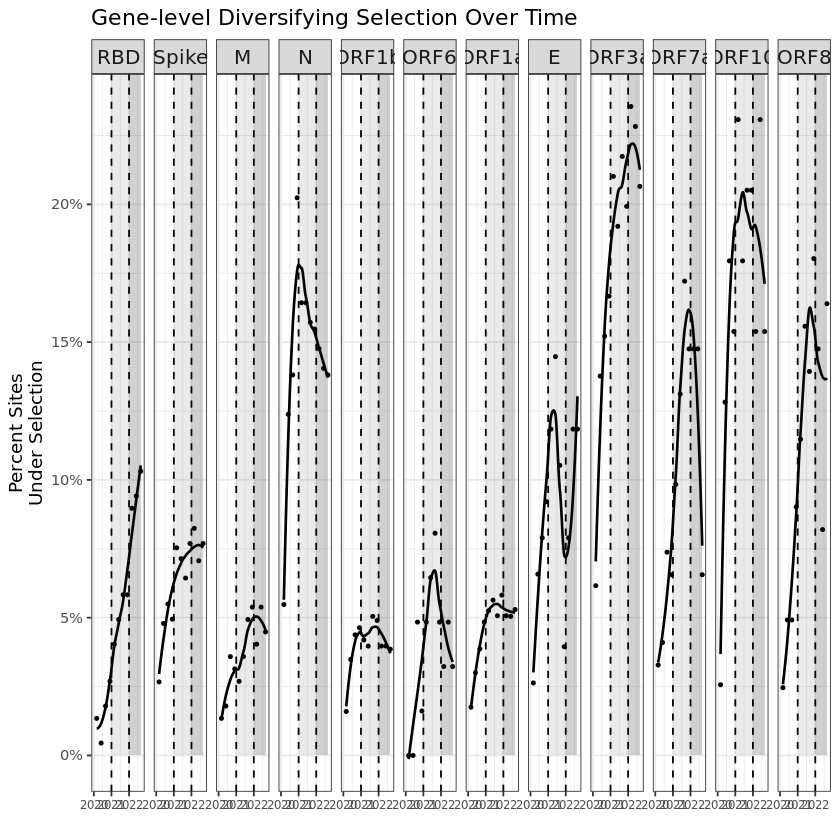

In [19]:
figure2d_diversifying<- tmp %>%
  mutate(gene = factor(gene, levels = ordered_genes))%>%
  filter(variable == "Diversifying Selection") %>%
  ggplot(aes(x = freeze_date, y = value, color = gene)) +
  geom_point(color = "black", size = 0.75) +
  geom_smooth(color = "black", se = FALSE, method = "loess", formula = y ~ x, size = 0.75) +
  facet_wrap(gene~., nrow = 1) +
  annotate('rect',xmin=vaccine_cutoff, xmax=omicron_cutoff, ymin=0, ymax=Inf, alpha=0.1, fill = "grey20") +
  annotate('rect',xmin=omicron_cutoff, xmax=max(tmp$freeze_date), ymin=0, ymax=Inf, alpha=0.2, fill = "grey10") +
  geom_vline(xintercept = vaccine_cutoff, linetype = "dashed") +
  geom_vline(xintercept = omicron_cutoff, linetype = "dashed") +
  ggtitle("Gene-level Diversifying Selection Over Time") +
  scale_color_manual(values = c(RColorBrewer::brewer.pal(8, "Dark2")[c(4,2,3,1,6,7)], "black", gray.colors(8)[-1*(1:2)]), name = "") +
  scale_y_continuous(name = "Percent Sites\nUnder Selection", labels = scales::label_percent(accuracy = 1L)) +
  scale_x_date(
    limits = c(as.Date("2020-01-01"), as.Date("2022-10-01")), 
     breaks = c(as.Date("2020-01-01"), as.Date("2021-01-01"), as.Date("2022-01-01")), 
     labels = scales::date_format("%Y"), 
    name = ""
  )+
  theme_bw()  +
  theme(legend.position = "right", axis.text.x = element_text(size=7), strip.text = element_text(size=12))

figure2d_diversifying



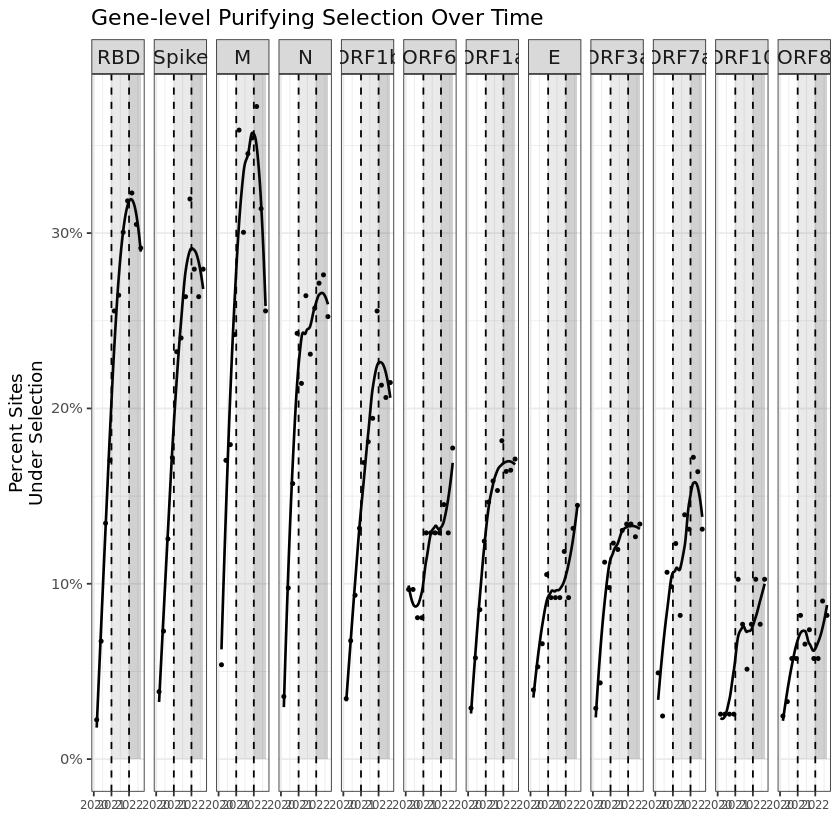

In [20]:

figure2d_purifying <- tmp %>%
  mutate(gene = factor(gene, levels = ordered_genes))%>%
  filter(variable == "Purifying Selection") %>%
  ggplot(aes(x = freeze_date, y = value, color = gene)) +
  geom_point(color = "black", size = 0.75) +
  geom_smooth(color = "black", se = FALSE, method = "loess", formula = y ~ x, size = 0.75) +
  facet_wrap(gene~., nrow = 1) +
  annotate('rect',xmin=vaccine_cutoff, xmax=omicron_cutoff, ymin=0, ymax=Inf, alpha=0.1, fill = "grey20") +
  annotate('rect',xmin=omicron_cutoff, xmax=as.Date("2022-09-01"), ymin=0, ymax=Inf, alpha=0.2, fill = "grey10") +
  geom_vline(xintercept = vaccine_cutoff, linetype = "dashed") +
  geom_vline(xintercept = omicron_cutoff, linetype = "dashed") +
  ggtitle("Gene-level Purifying Selection Over Time") +
  scale_color_manual(values = c(RColorBrewer::brewer.pal(8, "Dark2")[c(4,2,3,1,6,7)], "black", gray.colors(8)[-1*(1:2)]), name = "") +
  scale_y_continuous(name = "Percent Sites\nUnder Selection", labels = scales::label_percent(accuracy = 1L)) +
  scale_x_date(
    limits = c(as.Date("2020-01-01"), as.Date("2022-10-01")), 
     breaks = c(as.Date("2020-01-01"), as.Date("2021-01-01"), as.Date("2022-01-01")), 
     labels = scales::date_format("%Y"), 
    name = ""
  )+
  theme_bw()  +
  theme(legend.position = "right", axis.text.x = element_text(size=7), strip.text = element_text(size=12))

figure2d_purifying